# FarmVibes.AI Crop Segmentation - Inference

This notebook demonstrates how to ingest a trained crop land segmentation model into FarmVibes.AI environment and use it within an inference workflow to segment unseen regions.

------

### Micromamba environment setup
Before running this notebook, let's build a micromamba environment. If you do not have micromamba installed, please follow the instructions from the [micromamba installation guide](https://mamba.readthedocs.io/en/latest/installation/micromamba-installation.html).

```bash
$ micromamba env create -f ./crop_env.yaml
$ micromamba activate crop-seg
```


-------

### Notebook outline
In this notebook, we will use the model trained in [Local Training](./03_local_training.ipynb) or [AML Training](./03_aml_training.ipynb) notebooks to segment new regions. We will ingest the exported ONNX model file into the FarmVibes.AI platform and invoke an inference workflow to generate NDVI stacks and run the model over them.


Below are the main libraries used for this example and other useful links:
- **Model definition, training and exportation**:
    - [Pytorch](https://github.com/pytorch/pytorch) is used as our deep learning framework.
    - [TorchGeo](https://github.com/microsoft/torchgeo) is a library built for training models on geospatial data. We use it to dinamically sample fixed-sized chips to train/evaluate our model. We define torchgeo dataset at notebook_lib/datasets.py
    - [Pytorch-Lightning](https://github.com/Lightning-AI/lightning) is wrapper over pytorch to reduce boilerplate code for training and evaluating models. We define lightning modules at notebook_lib/modules.py.
    - [onnx](https://onnx.ai/get-started.html) is a library for exporting machine learning models to a interoperable format.


### Code organization 
The training code is mainly organized into:

- The datasets (`notebook_lib/datasets.py`) containing the code for loading and preparing the data produced by FarmVibes.AI.
- The lightning data module (`notebook_lib/modules.py`) contains the code for data loaders. The modules are responsible for loading NDVI and CDL rasters from FarmVibes.AI and pre-generate the chips to be uploaded to AML workspace. It also include the lightning data module employed within the AML pipeline to load and preprocess the training and validation chips. 
- The lightning module (`notebook_lib/models.py`) contains the code for running/training/evaluating the neural network: instantiating the neural network, training steps, computing metrics, and others. If you want to change the architecure, the loss, and generally how the model is trained, this is probably where you should go to. Also check [pytorch-lightning documentation](https://pytorch-lightning.readthedocs.io/en/latest/).
- Two utility subpackages (`notebook_lib/utils.py` and `notebook_lib/constants.py`) with supporting code for monitoring the workflow execution, defining crop indexes constants, etc.

------

### Imports & Constants

General and utility imports:

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import rasterio
from shapely import wkt

FarmVibes.AI imports and client setup:

In [2]:
import notebook_lib.constants as constants
from notebook_lib.modules import CropSegDataModule

from vibe_core.client import get_default_vibe_client

#Ratio between training and validation split  of the input region
VAL_RATIO = 0.3

# Instantiate the client
client = get_default_vibe_client()

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


### Define region and time range for inference

For running the inference, we will need to define the geometry and time range of interest for the inference. For simplicity, in this example, we will predict the whole region defined by `./input_region.wkt` (which encompasses both training and validation regions). 

In [3]:
input_geometry_path = "./input_region.wkt"
time_range = (datetime(2020, 1, 1), datetime(2020, 12, 31))

# Reading the geometry file
with open(input_geometry_path) as f:
    geometry = wkt.load(f)

### Inference setup

First, we need to add the model to the cluster. This can be done using the `farmvibes_ai.sh` script, for more information, see the [script documentation](../../documentation/FARMVIBES_SCRIPT.md).
Files added via the script will be available to the worker at `/mnt/onnx_resources`.

**Important: please, define the path to the ONNX model file before continuing.**

In [4]:
onnx_model_path = "PATH_TO_THE_MODEL"   # "~/farmvibes-ai/notebooks/crop_segmentation/crop_seg.onnx"
onnx_model_filename = onnx_model_path.split("/")[-1]    # "crop_seg.onnx"

Ingest the model to FarmVibes.AI cluster:

In [5]:
# Run command to add model to the cluster. You can also run this on a terminal
!farmvibes-ai local add-onnx $onnx_model_path

### Inference

Once ingested, we can use the model within workflows. In this example, we will use the `ml/crop_segmentation` inference workflow, which generates NDVI stacks for the region and time range of interest, runs the ingested model over them and outputs their predicted segmentation map.

In [6]:
client.document_workflow("ml/crop_segmentation")

Workflow: ml/crop_segmentation

Description:

Runs a crop segmentation model based on NDVI from SpaceEye imagery along the year. The workflow 
    generates SpaceEye cloud-free data for the input region and time range and computes NDVI over   
    those. NDVI values sampled regularly along the year are stacked as bands and used as input to   
    the crop segmentation model.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): Time range and geometry of interest.

Sinks:

- segmentation (vibe_core.data.rasters.Raster): Crop segmentation map at 10m resolution.

Parameters:

- pc_key (default: task defined): Planetary computer API key.

- model_file (default: task defined): Path to the ONNX file containing the model architecture   
    and weights.

- model_bands (default: 37): Number of NDVI bands to stack as the model input.

Tasks:

- spaceeye: Runs the SpaceEye cloud removal pipeline using an interpolation-based algorithm,    
    yielding daily cloud-free images for the input geometry and time range.

- ndvi: Computes an index (ndvi, evi, msavi, or methane) from an input raster.

- group

- inference

In [9]:
inference_run = client.run(
    "ml/crop_segmentation",
    "Crop segmentation inference",
    geometry=geometry,
    time_range=time_range,
    parameters={"model_file": onnx_model_filename}
)

inference_run.monitor()
print(inference_run.reason)

Output()

Workflow run was successful.


### Visualize the predicted crop land segmentation map

We will visualize the predicted map considering solely the validation region used in our training and compare it with the ground truth CDL map for that region.

Let's retrieve the CDL map for the validation from FarmVibes.AI:

In [10]:
# Run the workflow to retrieve cached results
wf_run = client.run("ml/dataset_generation/datagen_crop_segmentation",
                    "Retrieve dataset cached outputs",
                    geometry=geometry,
                    time_range=time_range
                    )

wf_run.monitor()

# Retrieve cached outputs
cdl_rasters = wf_run.output["cdl"]
ndvi_rasters = wf_run.output["ndvi"]

# Instantiate CropSegDataModule with default values
data = CropSegDataModule(
    ndvi_rasters,
    cdl_rasters,
    positive_indices=constants.CROP_INDICES,
    val_ratio=VAL_RATIO,
)
data.setup()

# Retrieve the ground-truth data
val_roi = data.val_dataloader().sampler.roi
gt_ar = data.val_dataset[val_roi]["mask"][0].numpy()

Output()

Converting CDLMask CRS from EPSG:5070 to EPSG:32611
Converting CDLMask resolution from 30.0 to 10.0


And plot the predicted map along with the ground-truth crop land map.

The model's output can be interpreted as a probability heatmap, in which pixels with higher activation/values (yellow color) represent regions assigned as crop land by the model, whereas pixels with lower values (blue color) are considered as non-crop regions. Similarly, the ground-truth image shows in yellow the crop land regions obtained from the CDL map. 

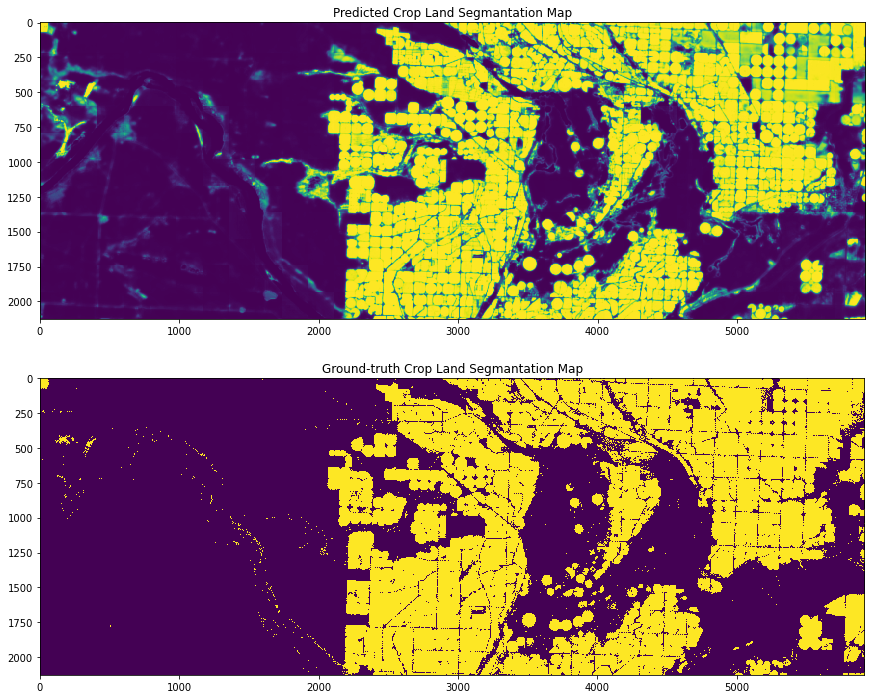

In [11]:
# Read inference results
with rasterio.open(inference_run.output["segmentation"][0].raster_asset.url) as src:
    data_ar = src.read(1)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.imshow(data_ar[:int(data_ar.shape[0] * VAL_RATIO)], interpolation="none")
plt.title("Predicted Crop Land Segmantation Map")
plt.subplot(2, 1, 2)
plt.imshow(gt_ar, interpolation="none")
plt.title("Ground-truth Crop Land Segmantation Map")
plt.show()